## Classification of Remotely Sensed Images

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from skimage import io
from skimage.transform import resize
import cv2 as cv
import random
from math import floor, ceil

In [2]:
import sys, os
from google.colab import drive

IMG_CLASSES = [
    'Airport','BareLand','BaseballField','Beach','Bridge',
    'Center','Church','Commercial','DenseResidential','Desert',
    'Farmland','Forest','Industrial','Meadow','MediumResidential','Mountain',
    'Park','Parking','Playground','Pond','Port','RailwayStation','Resort','River',
    'School','SparseResidential','Square','Stadium','StorageTanks','Viaduct'
]

DRIVE_PATH = r'/content/drive/My Drive/Colab Notebooks'
DATASET_PATH = os.path.join(DRIVE_PATH, r'AID/data/')
drive.mount('/content/drive')
sys.path.append(DRIVE_PATH)

Mounted at /content/drive


In [3]:
# Dataset parameters
#img_res = 150                  # Image resolution
NUM_IMGS_PER_CATEGORY = 100     # Total number of images to load from dataset
DATASET_SIZE = NUM_IMGS_PER_CATEGORY * len(IMG_CLASSES)   # Total number of images in dataset

In [31]:
def load_data(resolution):
  '''Load images and corresponding labels.'''
  img_data = []
  label_data = []

  # Load data from each category into array
  for i in range(len(IMG_CLASSES)):
    img_class = IMG_CLASSES[i]
    img_folder = os.path.join(DATASET_PATH, img_class)
    img_list = os.listdir(img_folder)[0:NUM_IMGS_PER_CATEGORY]
    for img_name in img_list:
      img_path = os.path.join(img_folder,img_name)
      img = np.array(io.imread(img_path))

      # Reduce image resolution and convert to 1D array
      img = resize(img,(resolution,resolution,3))
      img = img.flatten()
      img_data.append(img)

      # Append image label as number
      label_data.append(i)

  #print(img_data)
  # Shuffle images with their labels
  to_shuffle = list(zip(img_data, label_data))
  random.shuffle(to_shuffle)
  img_data, label_data = zip(*to_shuffle)
  img_data = list(img_data)
  label_data = list(label_data)

  img_data = np.array(img_data)

  # Visualize the data
  print("Data shape: {}".format(np.shape(img_data)))
  print("Label shape: {}".format(np.shape(label_data)))
  fig = plt.figure(figsize=(10,10))
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(img_data[i].reshape(resolution,resolution,3))
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
    plt.xlabel(IMG_CLASSES[label_data[i]])
  plt.suptitle("Resolution: {}x{}".format(resolution,resolution))

  return img_data, label_data


def make_dataset(resolution, amount_test=0.2):
  '''Make a training, test, and validation set from loaded data.'''
  # ratio_train is the ratio of training data to total data
  num_train = floor(DATASET_SIZE * (1 - amount_test))

  img_data, label_data = load_data(resolution)
  x_train, y_train = img_data[0:num_train], label_data[0:num_train]
  x_test, y_test = img_data[num_train:], label_data[num_train:]

  return x_train, y_train, x_test, y_test


Data shape: (3000, 7500)
Label shape: (3000,)
Data shape: (3000, 30000)
Label shape: (3000,)
Data shape: (3000, 67500)
Label shape: (3000,)


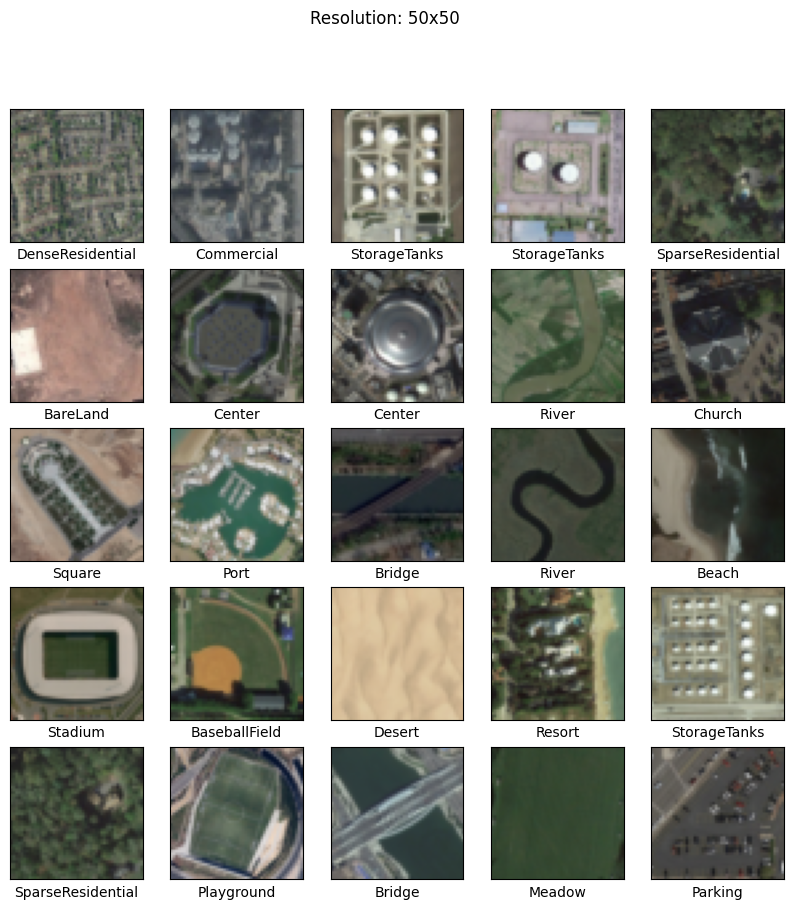

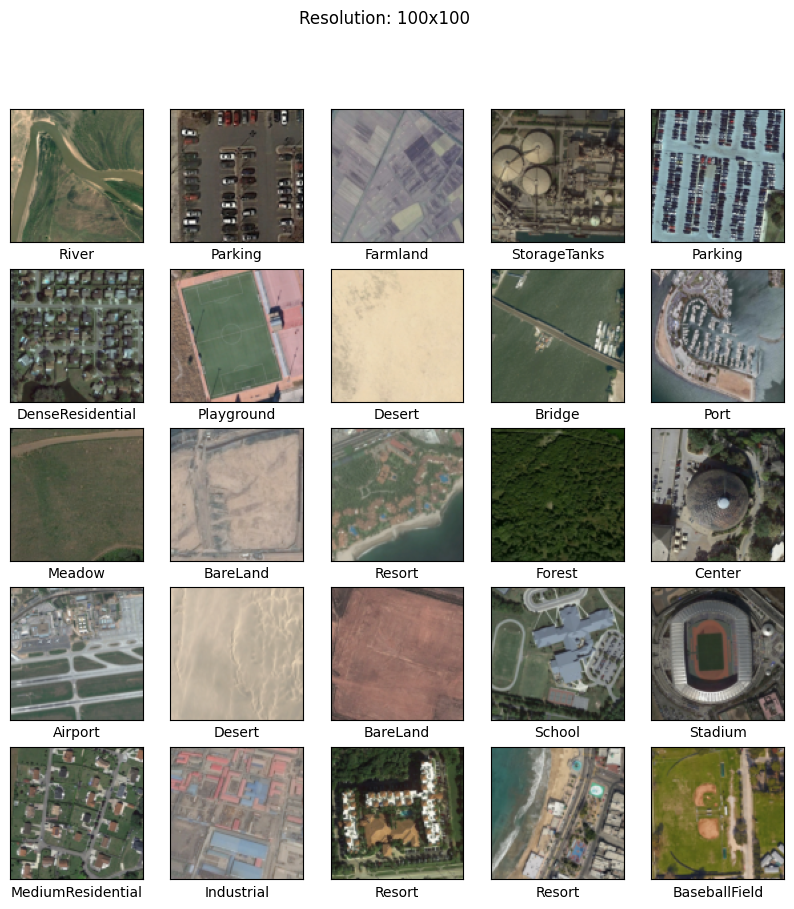

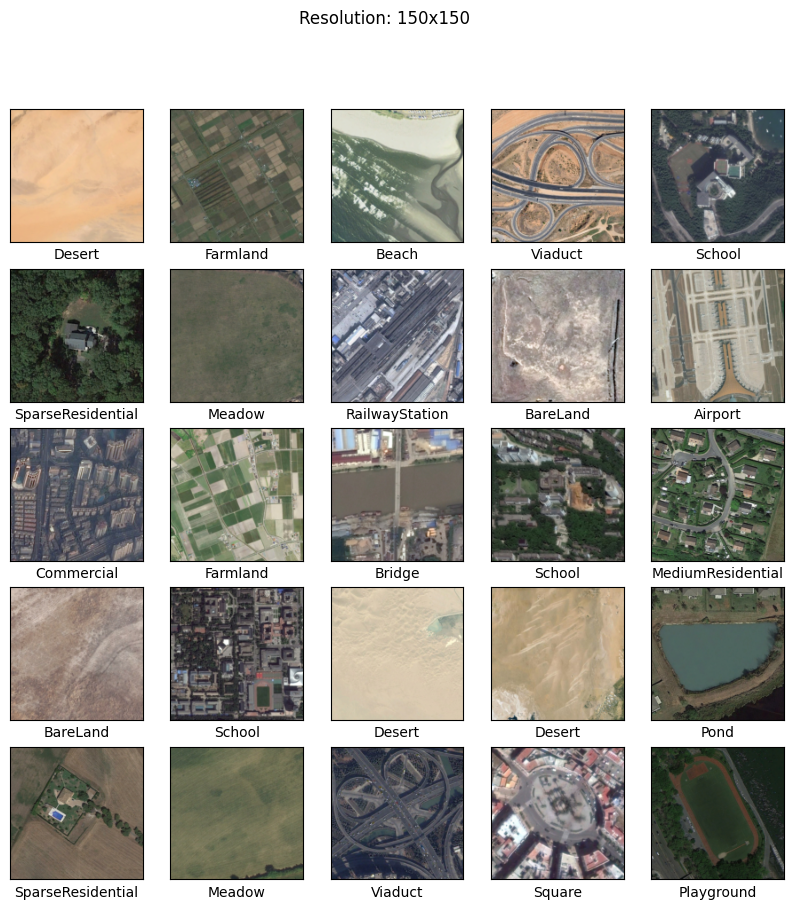

In [32]:
# Save copies of dataset at three different resolutions
resolution_vals = [('low-res',50), ('mid-res',100), ('hi-res',150)]
datasets = {'low-res':None,
            'mid-res':None,
            'hi-res' :None}

for text, val in resolution_vals:
  x_train, y_train, x_test, y_test = make_dataset(val)
  dataset = {'x_train': x_train,
             'y_train': y_train,
             'x_test':  x_test,
             'y_test':  y_test}
  datasets[text] = dataset

In [33]:
def load_dataset_copy(dataset_name, alpha=1, beta=0):
  '''Load copy of selected dataset'''
  dataset = datasets[dataset_name]
  x_train = np.ndarray.copy(dataset['x_train'])
  y_train = np.ndarray.copy(np.array(dataset['y_train']))
  x_test = np.ndarray.copy(dataset['x_test'])
  y_test = np.ndarray.copy(np.array(dataset['y_test']))

  # Adjust image contrast and brightness (optional - must 'denormalize' data)
  x_train = cv.convertScaleAbs(x_train*255, alpha=alpha, beta=beta) / 255
  x_test = cv.convertScaleAbs(x_test*255, alpha=alpha, beta=beta) / 255

  return x_train, y_train, x_test, y_test

In [54]:
# Experiment 1: test SVM accuracy on different dataset resolutions
for dataset_name in ['low-res', 'mid-res', 'hi-res']:
  x_train, y_train, x_test, y_test = load_dataset_copy(dataset_name)
  svc = SVC(kernel='linear')
  svc.fit(x_train, y_train)
  y_pred = svc.predict(x_test)
  print("Classification report for {} dataset:".format(dataset_name))
  print(classification_report(y_test, y_pred))

Classification report for low-res dataset:
              precision    recall  f1-score   support

           0       0.15      0.27      0.20        15
           1       0.55      0.77      0.64        22
           2       0.80      0.57      0.67        21
           3       0.32      0.45      0.38        20
           4       0.09      0.12      0.10        17
           5       0.29      0.45      0.36        11
           6       0.23      0.12      0.16        24
           7       0.33      0.28      0.30        18
           8       0.25      0.14      0.18        21
           9       0.81      0.81      0.81        26
          10       0.12      0.19      0.15        21
          11       0.36      0.75      0.49        16
          12       0.58      0.25      0.35        28
          13       0.28      0.75      0.41        16
          14       0.09      0.08      0.08        13
          15       0.06      0.07      0.06        14
          16       0.22      0.28     

In [46]:
# Experiment 2: Perform hyperparameter optimization using GridSearchCV
x_train, y_train, x_test, y_test = load_dataset_copy('low-res')
param_grid = [
    {'C':[1,10,100], 'kernel':['linear']},
    {'C':[1,10,100], 'gamma':[0.1,1,10], 'kernel':['rbf']},
    {'C':[1,10,100], 'degree':[4,5,6], 'kernel':['poly']}
]

svc = SVC()
scorer = make_scorer(f1_score, average='weighted')
hyperparam_tuning = GridSearchCV(svc,
                                 param_grid,
                                 scoring=scorer,
                                 return_train_score=True,
                                 verbose=2)
hyperparam_tuning.fit(x_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] END .................................C=1, kernel=linear; total time=  23.1s
[CV] END .................................C=1, kernel=linear; total time=  23.2s
[CV] END .................................C=1, kernel=linear; total time=  22.7s
[CV] END .................................C=1, kernel=linear; total time=  23.2s
[CV] END .................................C=1, kernel=linear; total time=  22.9s
[CV] END ................................C=10, kernel=linear; total time=  23.3s
[CV] END ................................C=10, kernel=linear; total time=  23.8s
[CV] END ................................C=10, kernel=linear; total time=  23.0s
[CV] END ................................C=10, kernel=linear; total time=  23.3s
[CV] END ................................C=10, kernel=linear; total time=  23.1s
[CV] END ...............................C=100, kernel=linear; total time=  23.2s
[CV] END ...............................C=100, 

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100], 'kernel': ['linear']},
                         {'C': [1, 10, 100], 'gamma': [0.1, 1, 10],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100], 'degree': [4, 5, 6],
                          'kernel': ['poly']}],
             return_train_score=True,
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [53]:
# After test, determine best model, params, and score
best_model = hyperparam_tuning.best_estimator_
best_params = hyperparam_tuning.best_params_
best_score = hyperparam_tuning.best_score_

print('Best model:', best_model)
print('Best parameter values:', best_params)
print('Best F1 score:', best_score)

# Put training data in form of dataframe
results = hyperparam_tuning.cv_results_
params = results['params']
scores = results['mean_test_score']
print('C  |   Gamma |   Degree  | Kernel  | Score')
i=0
for param in params:
  print(param['C'],end=",")
  if 'gamma' in param:
    print(param['gamma'],end="")
  print(',',end="")
  if 'degree' in param:
    print(param['degree'],end="")
  print(',',end="")
  print(param['kernel'],end="")
  print(',',end="")
  print(scores[i])
  i += 1

Best model: SVC(C=1, kernel='linear')
Best parameter values: {'C': 1, 'kernel': 'linear'}
Best F1 score: 0.28283001121449136
C  |   Gamma |   Degree  | Kernel  | Score
1,,,linear,0.28283001121449136
10,,,linear,0.28283001121449136
100,,,linear,0.28283001121449136
1,0.1,,rbf,0.09836851349550658
1,1,,rbf,0.005805536598765855
1,10,,rbf,0.004229390730783341
10,0.1,,rbf,0.10875991669758607
10,1,,rbf,0.007381792438130466
10,10,,rbf,0.004229390730783341
100,0.1,,rbf,0.10875991669758607
100,1,,rbf,0.007381792438130466
100,10,,rbf,0.004229390730783341
1,,4,poly,0.2748765291033793
1,,5,poly,0.2598569408319642
1,,6,poly,0.2410323415047056
10,,4,poly,0.27812721738697116
10,,5,poly,0.2653568812036927
10,,6,poly,0.24654721452869768
100,,4,poly,0.27953027329267605
100,,5,poly,0.2658436712634119
100,,6,poly,0.24544843797828655


In [57]:
# Experiment 3: Test effect of adjusting contrast and brightness independently
#print("alpha | beta | accuracy  | f1")
for alpha, beta in [(1,0),(1.2,0),(1.5,0),(1.7,0),(2.0,0),(2.5,0),(1,-0.5),(1,-0.2),(1,0.2),(1,0.5)]:
  x_train, y_train, x_test, y_test = load_dataset_copy(dataset_name,alpha,beta)
  svc = SVC(kernel='linear')
  svc.fit(x_train, y_train)
  y_pred = svc.predict(x_test)
  print("Classification report for {},{}:".format(alpha,beta))
  print(classification_report(y_test, y_pred))

Classification report for 1,0:
              precision    recall  f1-score   support

           0       0.16      0.23      0.19        22
           1       0.56      0.78      0.65        23
           2       0.55      0.43      0.48        14
           3       0.14      0.36      0.20        14
           4       0.26      0.29      0.27        28
           5       0.57      0.76      0.65        17
           6       0.23      0.33      0.27        15
           7       0.53      0.38      0.44        24
           8       0.17      0.05      0.07        21
           9       0.73      0.86      0.79        22
          10       0.11      0.28      0.16        18
          11       0.46      0.62      0.53        21
          12       0.40      0.24      0.30        17
          13       0.33      0.88      0.48        24
          14       0.14      0.06      0.08        17
          15       0.07      0.05      0.06        20
          16       0.26      0.37      0.30       

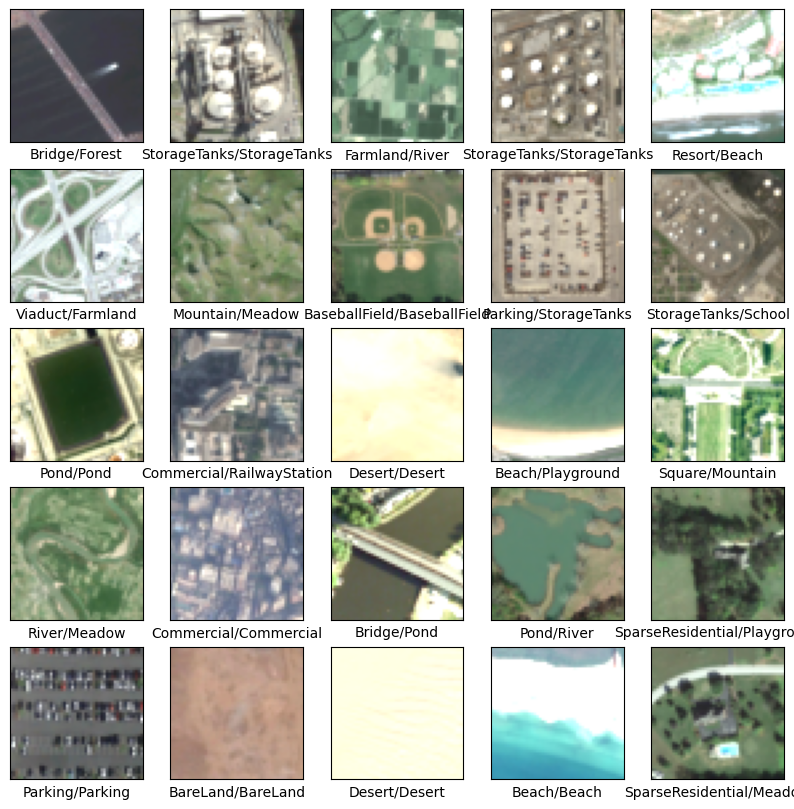

In [59]:
  # Plot images with actual/predicted labels
  x_train, y_train, x_test, y_test = load_dataset_copy('low-res',1.5,0)
  svc = SVC(kernel='linear')
  svc.fit(x_train, y_train)
  y_pred = svc.predict(x_test)

  fig = plt.figure(figsize=(10,10))
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(x_test[i].reshape(50,50,3))
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
    plt.xlabel("{}/{}".format(IMG_CLASSES[y_test[i]], IMG_CLASSES[y_pred[i]]))